In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap
from tqdm import tqdm
tqdm.pandas()
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from haversine import haversine
import lightgbm as lgb

In [2]:
# Load the dataset
data = pd.read_csv('/Users/sridivyagorantla/Downloads/nyc-taxi-trip-duration/train.csv')

In [3]:
# Overview of the dataset
print(data.head())
print(data.info())

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731

In [4]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [5]:
# Check for missing value
print("\nMissing Values in Train Dataset:\n", data.isnull().sum())


Missing Values in Train Dataset:
 id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [6]:
print(data['passenger_count'].describe())

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64


In [7]:
print(data['trip_duration'].describe())

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64


In [10]:
# Check the shape of the datasets
print(f"Dataset Shape: {data.shape}")

Dataset Shape: (1458644, 11)


In [11]:
# Drop unnecessary columns
data = data.drop(columns=['id'])

# Remove rows with negative or zero trip durations
data = data[data['trip_duration'] > 0]

In [12]:
#Calculate the distance between the picup and drop off locations
def vec_haversine(row):
    return haversine((row['pickup_latitude'], row['pickup_longitude']),(row['dropoff_latitude'], row['dropoff_longitude']))

In [13]:
data['trip_distance'] = data.progress_apply(vec_haversine, axis=1)

100%|█████████████████████████████| 1458644/1458644 [00:10<00:00, 139817.71it/s]


In [14]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385107
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485500
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590


In [23]:
mean=data['trip_duration'].mean()
print(mean)
median=data['trip_duration'].median()
print(median)
StandardDeviation = data['trip_distance'].std()
print(StandardDeviation)

959.4922729603659
662.0
4.296543965150485


In [24]:
# Find the number of unique vendor IDs in the dataset
unique_vendor_ids = data['vendor_id'].unique()
print(f"Unique Vendor IDs: {unique_vendor_ids}")
print(f"Number of Unique Vendor IDs: {len(unique_vendor_ids)}")

Unique Vendor IDs: [2 1]
Number of Unique Vendor IDs: 2


In [25]:
# Count the number of trips for each vendor
trip_counts = data['vendor_id'].value_counts()
print(trip_counts)

vendor_id
2    780302
1    678342
Name: count, dtype: int64


Filtering and Sorting

In [26]:
#Filter trips that had exactly 1 passenger and lasted more than 20 minutes
df_filtered = data[(data['passenger_count'] == 1) & (data['trip_duration'] > 20*60)]  # Convert 20 minutes to seconds
df_filtered.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385107
7,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,5.714989
9,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,5.121169
10,2,2016-05-10 22:08:41,2016-05-10 22:29:55,1,-73.982651,40.763840,-74.002228,40.732990,N,1274,3.806145
14,2,2016-05-27 00:43:36,2016-05-27 01:07:10,1,-73.992195,40.727226,-73.974655,40.783070,N,1414,6.382845


In [27]:
#Filter trips that lasted more than one day day
data[(data['trip_duration'] > 60*60*24)]

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance
355003,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,20.148692
680594,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,5.982495
924150,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,1.635130
978383,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,19.900689


In [28]:
#Find count of trips that started and ended on different days
data_filtered = data[(pd.to_datetime(data['pickup_datetime']).dt.date) != \
                 (pd.to_datetime(data['dropoff_datetime']).dt.date)]
df_filtered.shape

(203845, 11)

In [29]:
def category_func(duration):
    if duration < 10*60:
        return 'short'
    if duration <= 30*60:
        return 'medium'
    if duration > 30*60:
        return 'long'
data['trip_category'] = data['trip_duration'].apply(category_func)
data.groupby('trip_category').size()

trip_category
long      113118
medium    693925
short     651601
dtype: int64

In [30]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance,trip_category
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,short
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,medium
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385107,long
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485500,short
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,short


In [31]:
# Convert pickup_datetime to datetime format and convert to date pickup_date
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_date'] = data['pickup_datetime'].dt.date

# Extract useful time-based features
for df in [data]:
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday

In [32]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance,trip_category,pickup_date,pickup_hour,pickup_day,pickup_month,pickup_weekday
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,short,2016-03-14,17,14,3,0
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,medium,2016-06-12,0,12,6,6
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385107,long,2016-01-19,11,19,1,1
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485500,short,2016-04-06,19,6,4,2
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,short,2016-03-26,13,26,3,5


In [33]:
#Calculate the minimum and maximum number of passengers per trip
display(data['passenger_count'].min(), data['passenger_count'].max())

np.int64(0)

np.int64(9)

In [34]:
def flag_convert(x):
    if(x == 'N'):
        return 0
    else: return 1
    
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].apply(lambda x : flag_convert(x))

In [35]:
 #function to convert the trip duration from hours to second and create a new column.
data['trip_duration_hours'] = data['trip_duration'].apply(lambda second : second / ( 60 * 60))
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance,trip_category,pickup_date,pickup_hour,pickup_day,pickup_month,pickup_weekday,trip_duration_hours
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,1.498523,short,2016-03-14,17,14,3,0,0.126389
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.805510,medium,2016-06-12,0,12,6,6,0.184167
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,6.385107,long,2016-01-19,11,19,1,1,0.590000
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,1.485500,short,2016-04-06,19,6,4,2,0.119167
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,1.188590,short,2016-03-26,13,26,3,5,0.120833


In [36]:
airports = {
    'JFK': {'latitude': 40.6413, 'longitude': -73.7781},
    'LGA': {'latitude': 40.7769, 'longitude': -73.8740},
    'EWR': {'latitude': 40.6895, 'longitude': -74.1745}
}

In [37]:
def check_airport_proximity(lat, lon, airport_locations, max_distance=0.5):
    distances = [
        haversine((lat, lon), (airport['latitude'], airport['longitude']), unit='km') 
        for airport in airport_locations.values()
    ]
    return int(any(dist <= max_distance for dist in distances))

In [38]:
data['pickup_at_airport'] = data.apply(
    lambda row: check_airport_proximity(
        row['pickup_latitude'], row['pickup_longitude'], airports, max_distance=0.5
    ), axis=1
)

In [39]:
data['dropoff_at_airport'] = data.apply(
    lambda row: check_airport_proximity(
        row['dropoff_latitude'], row['dropoff_longitude'], airports, max_distance=0.5
    ), axis=1
)

In [40]:
print(data[['pickup_latitude', 'pickup_longitude', 'pickup_at_airport', 
          'dropoff_latitude', 'dropoff_longitude', 'dropoff_at_airport']].head())

   pickup_latitude  pickup_longitude  pickup_at_airport  dropoff_latitude  \
0        40.767937        -73.982155                  0         40.765602   
1        40.738564        -73.980415                  0         40.731152   
2        40.763939        -73.979027                  0         40.710087   
3        40.719971        -74.010040                  0         40.706718   
4        40.793209        -73.973053                  0         40.782520   

   dropoff_longitude  dropoff_at_airport  
0         -73.964630                   0  
1         -73.999481                   0  
2         -74.005333                   0  
3         -74.012268                   0  
4         -73.972923                   0  


In [41]:
pickup_airport_counts = data['pickup_at_airport'].value_counts()
print(pickup_airport_counts)

dropoff_airport_counts = data['dropoff_at_airport'].value_counts()
print(dropoff_airport_counts)

pickup_at_airport
0    1429708
1      28936
Name: count, dtype: int64
dropoff_at_airport
0    1446314
1      12330
Name: count, dtype: int64


In [42]:
manhattan_bounds = {
    'min_lat': 40.70,  
    'max_lat': 40.88, 
    'min_lon': -74.02, 
    'max_lon': -73.90
}

In [43]:
def is_within_nyc(lat, lon):
    return manhattan_bounds['min_lat'] <= lat <= manhattan_bounds['max_lat'] and manhattan_bounds['min_lon'] <= lon <= manhattan_bounds['max_lon']

In [44]:
data['pickup_within_nyc_manh'] = data.progress_apply(
    lambda data: is_within_nyc(data['pickup_latitude'], data['pickup_longitude']), axis=1)

100%|█████████████████████████████| 1458644/1458644 [00:07<00:00, 195262.47it/s]


In [45]:
data['dropoff_within_nyc_manh'] = data.progress_apply(
    lambda data: is_within_nyc(data['dropoff_latitude'], data['dropoff_longitude']), axis=1)

100%|█████████████████████████████| 1458644/1458644 [00:07<00:00, 193650.28it/s]


In [46]:
#  within region

print(data[['pickup_latitude', 'pickup_longitude', 'pickup_within_nyc_manh', 
          'dropoff_latitude', 'dropoff_longitude', 'dropoff_within_nyc_manh']].head())

   pickup_latitude  pickup_longitude  pickup_within_nyc_manh  \
0        40.767937        -73.982155                    True   
1        40.738564        -73.980415                    True   
2        40.763939        -73.979027                    True   
3        40.719971        -74.010040                    True   
4        40.793209        -73.973053                    True   

   dropoff_latitude  dropoff_longitude  dropoff_within_nyc_manh  
0         40.765602         -73.964630                     True  
1         40.731152         -73.999481                     True  
2         40.710087         -74.005333                     True  
3         40.706718         -74.012268                     True  
4         40.782520         -73.972923                     True  


In [47]:
#Active time by hour (daily activity)
hourly_activity = data.groupby(['pickup_hour', 'vendor_id']).size().reset_index(name='trip_count')

# Active time by week (yearly activity)
weekly_activity = data.groupby(['pickup_weekday', 'vendor_id']).size().reset_index(name='trip_count')

# Active time by month (monthly activity)
monthly_activity = data.groupby(['pickup_month', 'vendor_id']).size().reset_index(name='trip_count')

# Display results
print("Hourly Activity:")
print(hourly_activity)

print("\nweekly Activity:")
print(weekly_activity)

print("\nMonthly Activity:")
print(monthly_activity)

Hourly Activity:
    pickup_hour  vendor_id  trip_count
0             0          1       24561
1             0          2       28687
2             1          1       18090
3             1          2       20481
4             2          1       13570
5             2          2       14402
6             3          1       10399
7             3          2       10496
8             4          1        7827
9             4          2        7965
10            5          1        7581
11            5          2        7421
12            6          1       16218
13            6          2       17030
14            7          1       26068
15            7          2       29532
16            8          1       31103
17            8          2       35950
18            9          1       31145
19            9          2       36518
20           10          1       29793
21           10          2       35644
22           11          1       31262
23           11          2       37214
24      

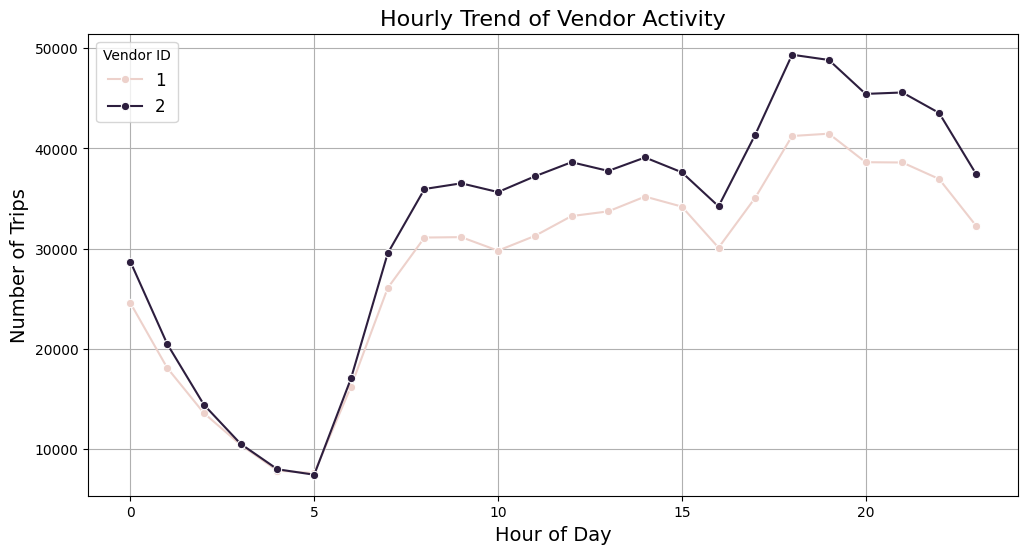

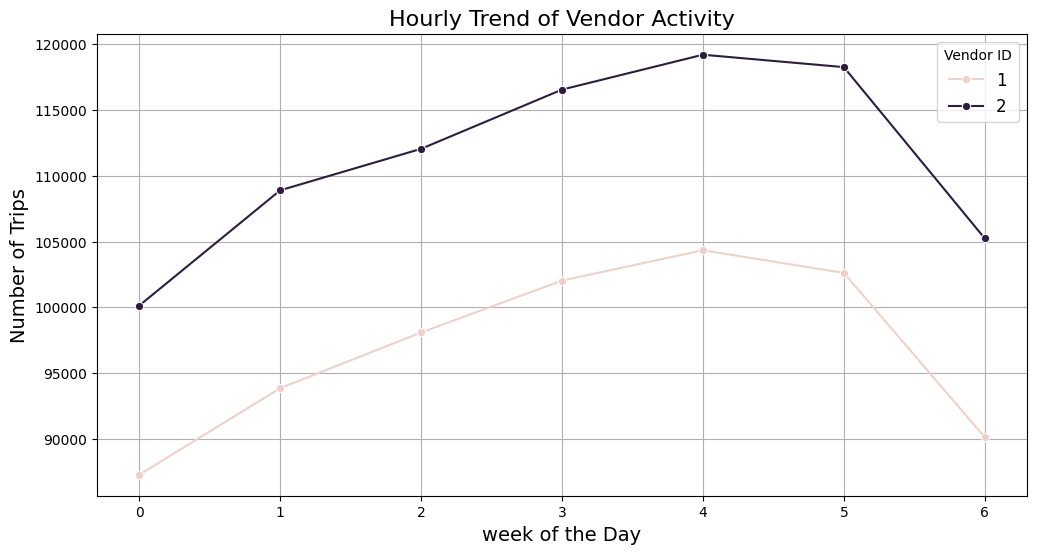

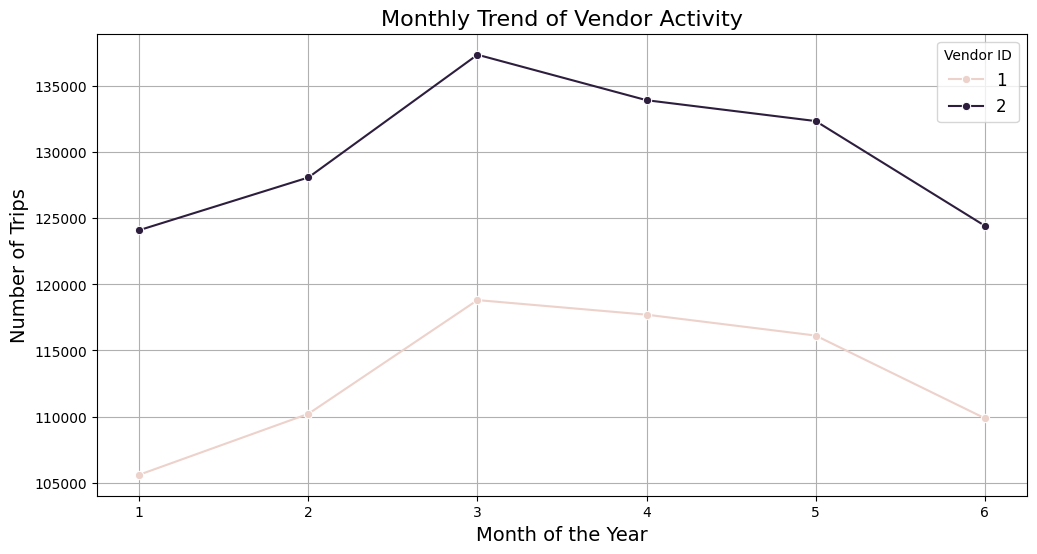

In [48]:
# Function to create trend line plots
def plot_trend_line(activity_data, x_col, title, xlabel):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=activity_data, x=x_col, y='trip_count', hue='vendor_id', marker='o')
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Number of Trips', fontsize=14)
    plt.legend(title='Vendor ID', fontsize=12)
    plt.grid()
    plt.show()

# Plot hourly trend
plot_trend_line(hourly_activity, 'pickup_hour', 'Hourly Trend of Vendor Activity', 'Hour of Day')

# Plot hourly trend
plot_trend_line(weekly_activity, 'pickup_weekday', 'Hourly Trend of Vendor Activity', 'week of the Day')

# Plot monthly trend
plot_trend_line(monthly_activity, 'pickup_month', 'Monthly Trend of Vendor Activity', 'Month of the Year')

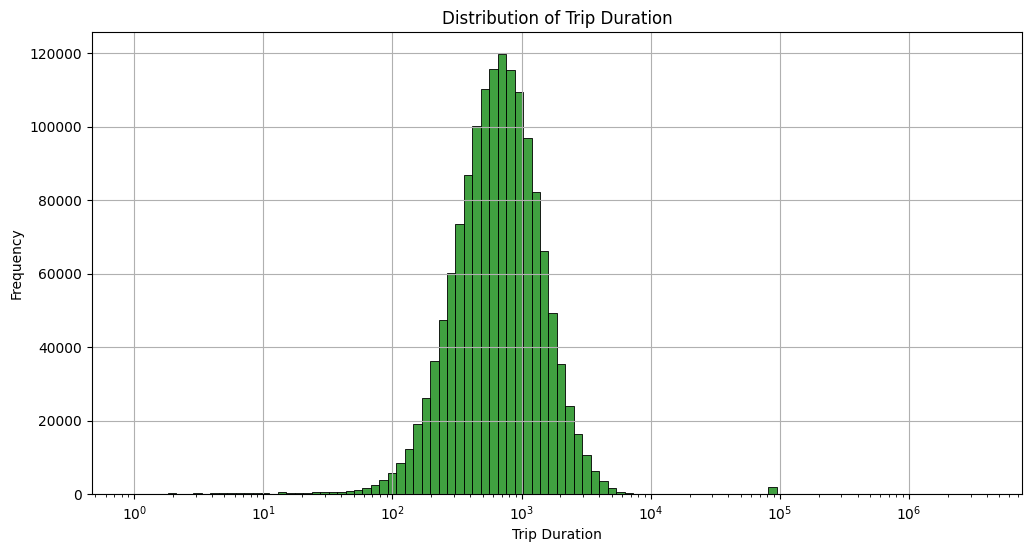

In [49]:
plt.figure(figsize=(12, 6))
sns.histplot(data['trip_duration'], bins=100, kde=False, color='Green', log_scale=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.grid()
plt.show()

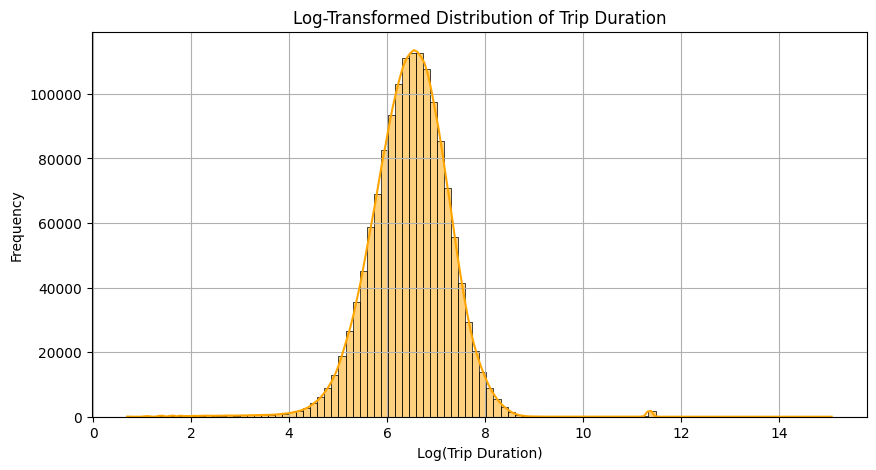

In [50]:
data['log_trip_duration'] = np.log1p(data['trip_duration'])

plt.figure(figsize=(10, 5))
sns.histplot(data['log_trip_duration'], bins=100, kde=True, color='orange')
plt.title('Log-Transformed Distribution of Trip Duration')
plt.xlabel('Log(Trip Duration)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

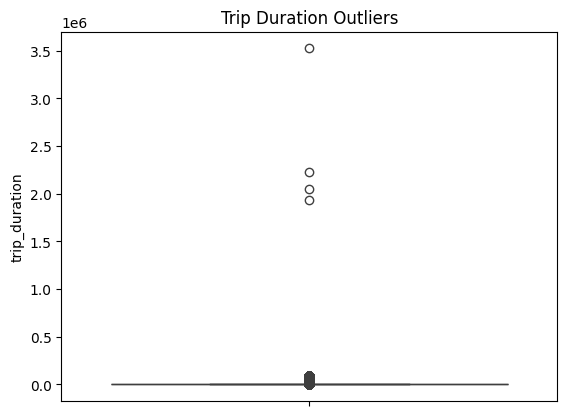

In [51]:
# Check for outliers in trip duration
sns.boxplot(data['trip_duration'])
plt.title("Trip Duration Outliers")
plt.show()

In [52]:
# Remove extreme outliers
data = data[data['trip_duration'] < data['trip_duration'].quantile(0.99)]

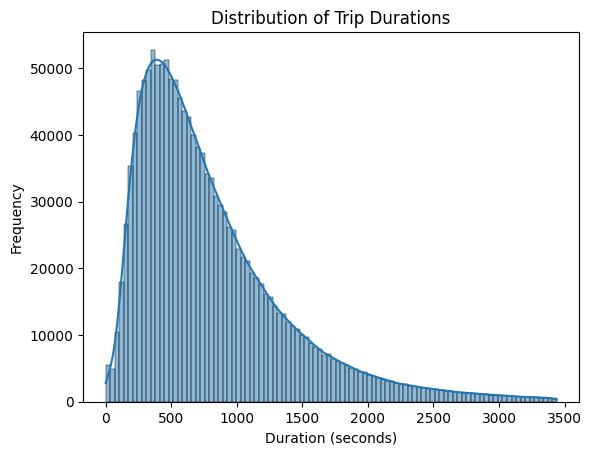

In [53]:
# Distribution of trip durations
sns.histplot(data['trip_duration'], bins=100, kde=True)
plt.title("Distribution of Trip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

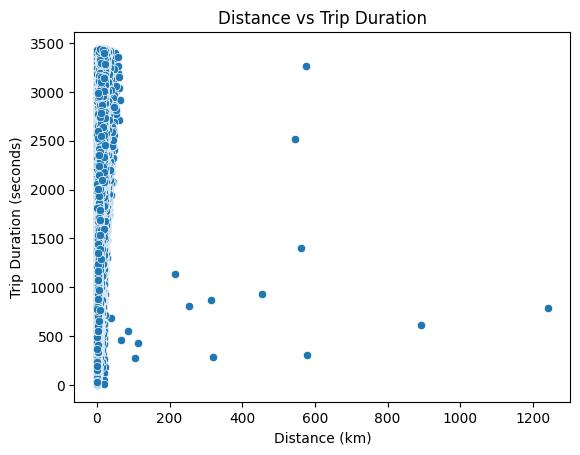

In [54]:
# Scatter plot of distance vs trip duration
sns.scatterplot(x='trip_distance', y='trip_duration', data=data)
plt.title("Distance vs Trip Duration")
plt.xlabel("Distance (km)")
plt.ylabel("Trip Duration (seconds)")
plt.show()

/var/folders/k4/8j7wz2kd6md0m37vlydsjm280000gn/T/ipykernel_37618/1004892010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['speed'] = data.apply(lambda speed : speed['trip_distance'] / speed['trip_duration_hours'], axis = 1)


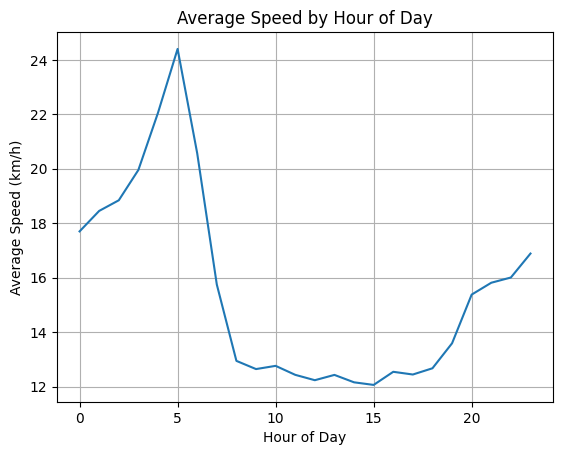

In [55]:
#function to create a new column speed (distance divided by duration in hours)
data['speed'] = data.apply(lambda speed : speed['trip_distance'] / speed['trip_duration_hours'], axis = 1)

speed=data.groupby(pd.to_datetime(data['pickup_datetime']).dt.hour)['speed'].agg(['mean','median'])

speed["mean"].plot(
    kind="line",
    title="Average Speed by Hour of Day",
    xlabel="Hour of Day",
    ylabel="Average Speed (km/h)",
)
plt.grid(True)
plt.show()

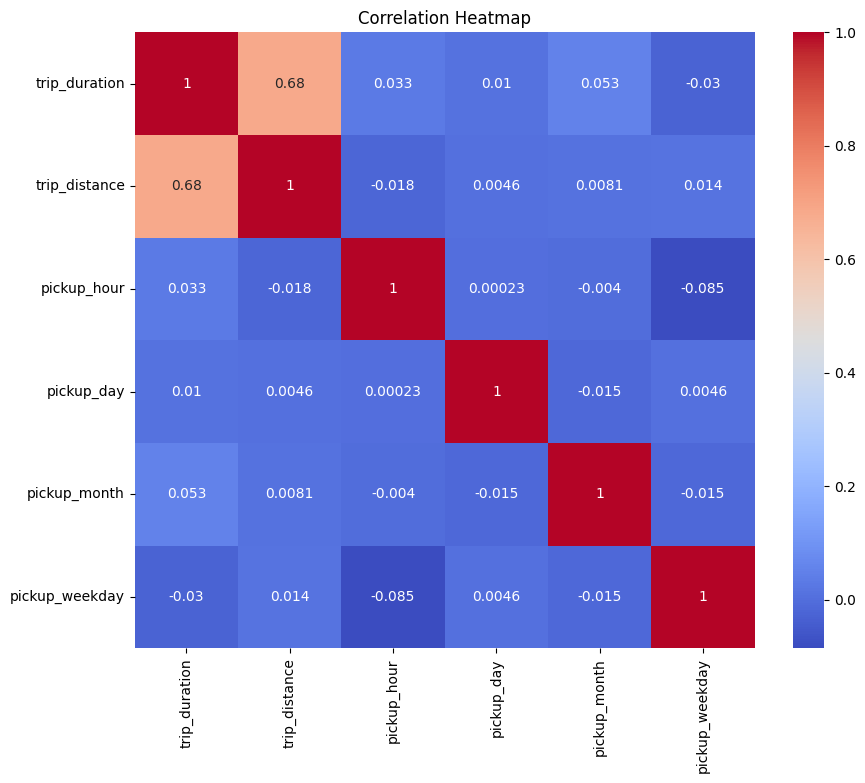

In [56]:
# Correlation heatmap
correlation_matrix = data[['trip_duration', 'trip_distance', 'pickup_hour', 'pickup_day', 'pickup_month', 'pickup_weekday']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [57]:
#Pickup Locations Heatmap

# Prepare data for heatmap
pickup_locations = data[['pickup_latitude', 'pickup_longitude']].dropna()
pickup_locations = pickup_locations.sample(10000)  # Use a sample to avoid overloading the map

# Initialize map
pickup_heatmap = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add heatmap
HeatMap(data=pickup_locations.values, radius=8).add_to(pickup_heatmap)

# Save the map
pickup_heatmap.save("/Users/sridivyagorantla/Downloads/nyc-taxi-trip-duration/pickup_heatmap.html")
print("Pickup locations heatmap saved.")

Pickup locations heatmap saved.


In [58]:
#Dropoff Locations Heatmap

# Prepare data for heatmap
dropoff_locations = data[['dropoff_latitude', 'dropoff_longitude']].dropna()
dropoff_locations = dropoff_locations.sample(10000)  # Use a sample for efficiency

# Initialize map
dropoff_heatmap = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add heatmap
HeatMap(data=dropoff_locations.values, radius=8).add_to(dropoff_heatmap)

# Save the map
dropoff_heatmap.save("/Users/sridivyagorantla/Downloads/nyc-taxi-trip-duration/dropoff_heatmap.html")
print("Dropoff locations heatmap saved.")

Dropoff locations heatmap saved.


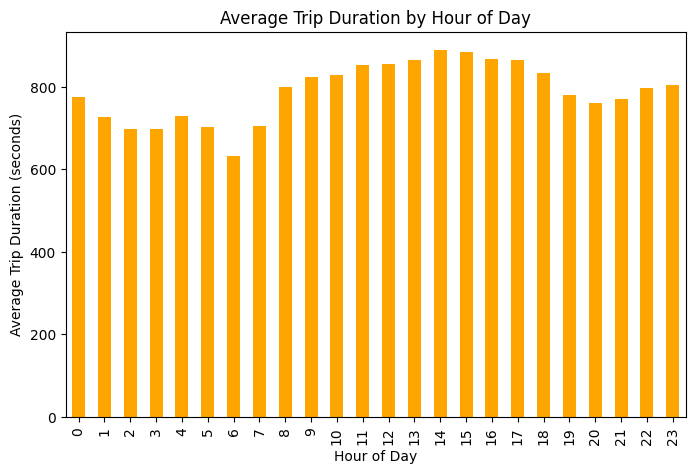

In [59]:
#Average Trip Duration by Hour

# Average trip duration by pickup hour
hourly_avg_duration = data.groupby('pickup_hour')['trip_duration'].mean()

plt.figure(figsize=(8, 5))
hourly_avg_duration.plot(kind='bar', color='orange')
plt.title("Average Trip Duration by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Trip Duration (seconds)")
plt.show()

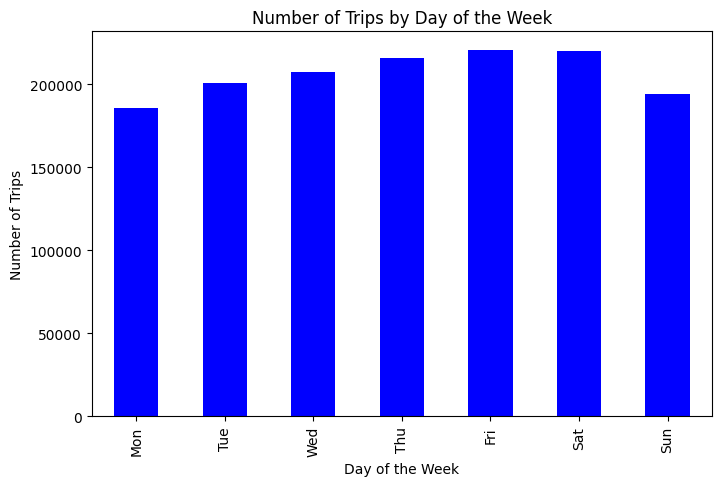

In [60]:
#Number of Trips by Day of the Week

# Number of trips by day of the week
weekday_counts = data.groupby('pickup_weekday').size()

plt.figure(figsize=(8, 5))
weekday_counts.plot(kind='bar', color='blue')
plt.title("Number of Trips by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Trips")
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

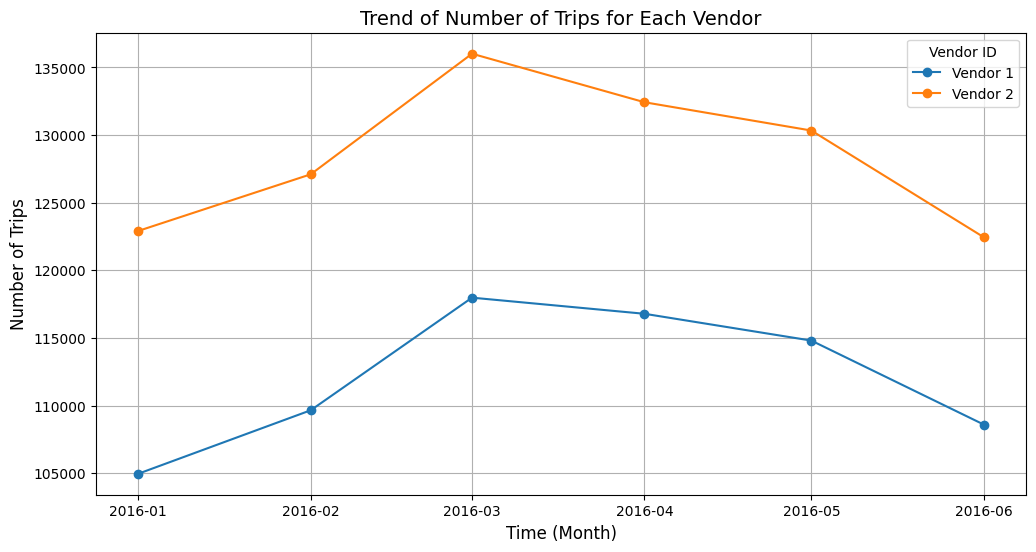

In [61]:
# Group data by vendor and date (e.g., monthly)
trend_data = data.groupby([data['pickup_datetime'].dt.to_period('M'), 'vendor_id']).size().reset_index(name='trip_count')

# Convert 'pickup_datetime' to datetime for plotting
trend_data['pickup_datetime'] = trend_data['pickup_datetime'].dt.to_timestamp()

# Plotting the trend lines
plt.figure(figsize=(12, 6))
for vendor_id in trend_data['vendor_id'].unique():
    vendor_data = trend_data[trend_data['vendor_id'] == vendor_id]
    plt.plot(vendor_data['pickup_datetime'], vendor_data['trip_count'], marker='o', label=f'Vendor {vendor_id}')

# Adding labels and title
plt.xlabel('Time (Month)', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Trend of Number of Trips for Each Vendor', fontsize=14)
plt.legend(title='Vendor ID', fontsize=10)
plt.grid()
plt.show()

In [62]:
# Select features for the model
features = ['pickup_hour', 'pickup_day', 'pickup_month', 'trip_distance']
X = data[features]
y = data['trip_duration']

In [63]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the datasets
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (1155240, 4), Test set: (288811, 4)


In [64]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [65]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 417.4256115817132
R-squared (R²): 0.47263585254989415


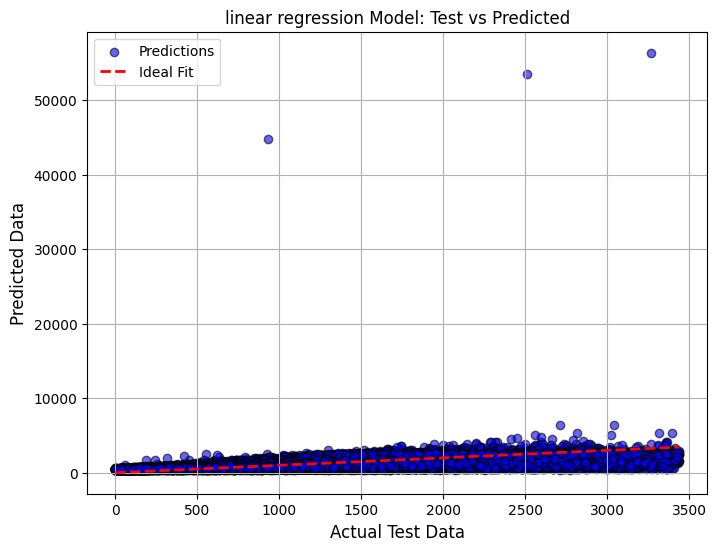

In [66]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Fit")
plt.title("linear regression Model: Test vs Predicted")
plt.xlabel("Actual Test Data", fontsize=12)
plt.ylabel("Predicted Data", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [68]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 331.05260751202945
R-squared (R²): 0.668299258191339


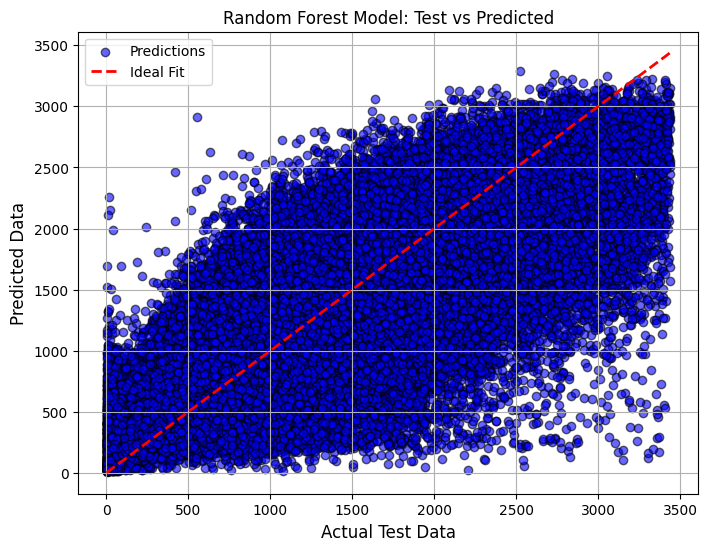

In [69]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Fit")
plt.title("Random Forest Model: Test vs Predicted")
plt.xlabel("Actual Test Data", fontsize=12)
plt.ylabel("Predicted Data", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [70]:
model = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=2)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      random_state=42)

In [71]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 323.1414246463618
R-squared (R²): 0.6839631768129693


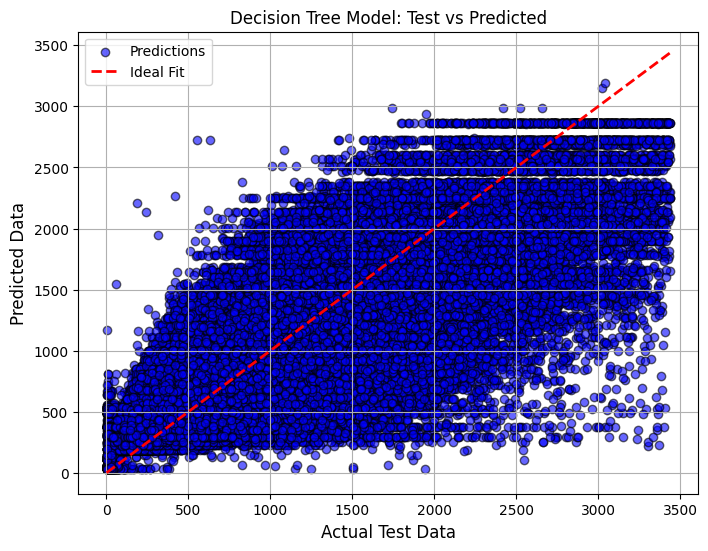

In [72]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Fit")
plt.title("Decision Tree Model: Test vs Predicted")
plt.xlabel("Actual Test Data", fontsize=12)
plt.ylabel("Predicted Data", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# Set up LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test)

# Define parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train model
model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[val_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 318.96


In [81]:
# Predict on validation set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 318.96039527098014
R-squared (R²): 0.6920884792786147


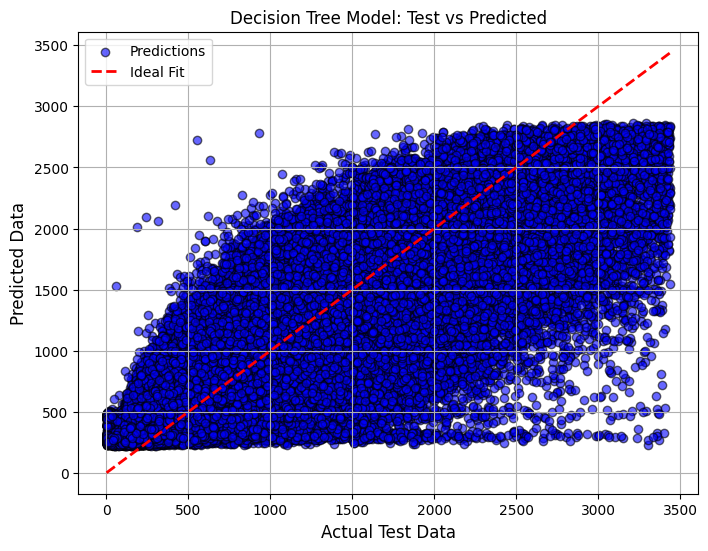

In [82]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Fit")
plt.title("Decision Tree Model: Test vs Predicted")
plt.xlabel("Actual Test Data", fontsize=12)
plt.ylabel("Predicted Data", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()